In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500
sp500.Symbol = sp500.Symbol.str.replace('.','-')
tickers = sp500.Symbol.tolist()
import yfinance as yf
import datetime as dt
data = yf.download(tickers, 
                   start ='2015-9-29',
                   end=dt.datetime.now())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  503 of 503 completed


In [5]:
data.head()
data.columns

MultiIndex([( 'Close',    'A'),
            ( 'Close', 'AAPL'),
            ( 'Close', 'ABBV'),
            ( 'Close', 'ABNB'),
            ( 'Close',  'ABT'),
            ( 'Close', 'ACGL'),
            ( 'Close',  'ACN'),
            ( 'Close', 'ADBE'),
            ( 'Close',  'ADI'),
            ( 'Close',  'ADM'),
            ...
            ('Volume',  'WTW'),
            ('Volume',   'WY'),
            ('Volume', 'WYNN'),
            ('Volume',  'XEL'),
            ('Volume',  'XOM'),
            ('Volume',  'XYL'),
            ('Volume',  'YUM'),
            ('Volume',  'ZBH'),
            ('Volume', 'ZBRA'),
            ('Volume',  'ZTS')],
           names=['Price', 'Ticker'], length=2515)

In [6]:
data = data.stack()

C:\Users\gaikw\AppData\Local\Temp\ipykernel_23076\3598274568.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data = data.stack()


In [7]:
data.index.names = ['date','tickers']
data.columns = data.columns.str.lower()
data

Price                    close        high         low        open  \
date       tickers                                                   
2015-09-29 A         31.251011   31.547404   30.787896   30.899042   
           AAPL      24.536385   25.537549   24.266409   25.384562   
           ABBV      35.061211   35.991039   34.456822   35.267100   
           ABT       32.820751   33.360841   32.430225   32.621333   
           ACGL      23.217773   23.255808   22.916655   22.983217   
...                        ...         ...         ...         ...   
2025-06-18 XYL      125.129997  126.269997  125.000000  125.480003   
           YUM      138.360001  140.740005  137.970001  140.130005   
           ZBH       90.550003   91.099998   89.660004   90.260002   
           ZBRA     291.730011  296.730011  289.079987  289.890015   
           ZTS      155.059998  158.100006  154.539993  157.089996   

Price                    volume  
date       tickers               
2015-09-29 A          2252400.0  
           AAPL     293461600.0  
           ABBV      12842800.0  
           ABT       12287500.0  
           ACGL       1888800.0  
...                         ...  
2025-06-18 XYL         931900.0  
           YUM        1539500.0  
           ZBH        1915300.0  
           ZBRA        571200.0  
           ZTS        4661700.0  

[1197764 rows x 5 columns]

# We calculate the features and technical indicators for each stock

In [8]:
#here i dont have the adjacent close column so i am using the close column
data['garman_klass_vol'] = (np.log(data.high) - np.log(data.low))**2/2 - (2*np.log(2)-1)*(np.log(data.close) - np.log(data.open))**2
data

Price                    close        high         low        open  \
date       tickers                                                   
2015-09-29 A         31.251011   31.547404   30.787896   30.899042   
           AAPL      24.536385   25.537549   24.266409   25.384562   
           ABBV      35.061211   35.991039   34.456822   35.267100   
           ABT       32.820751   33.360841   32.430225   32.621333   
           ACGL      23.217773   23.255808   22.916655   22.983217   
...                        ...         ...         ...         ...   
2025-06-18 XYL      125.129997  126.269997  125.000000  125.480003   
           YUM      138.360001  140.740005  137.970001  140.130005   
           ZBH       90.550003   91.099998   89.660004   90.260002   
           ZBRA     291.730011  296.730011  289.079987  289.890015   
           ZTS      155.059998  158.100006  154.539993  157.089996   

Price                    volume  garman_klass_vol  
date       tickers                                 
2015-09-29 A          2252400.0          0.000247  
           AAPL     293461600.0          0.000857  
           ABBV      12842800.0          0.000936  
           ABT       12287500.0          0.000386  
           ACGL       1888800.0          0.000068  
...                         ...               ...  
2025-06-18 XYL         931900.0          0.000048  
           YUM        1539500.0          0.000135  
           ZBH        1915300.0          0.000123  
           ZBRA        571200.0          0.000326  
           ZTS        4661700.0          0.000194  

[1197764 rows x 6 columns]

In [9]:
data['SMA20'] = data['close'].rolling(window=20).mean()
data['STD20'] = data['close'].rolling(window=20).std()

<Axes: xlabel='date'>

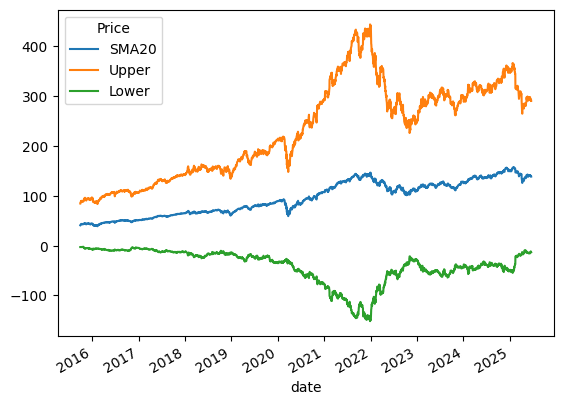

In [10]:
data['Upper'] = data['SMA20'] + 2*data.STD20
data['Lower'] = data['SMA20'] - 2*data.STD20
data.xs('AAPL',level = 1)[['SMA20','Upper','Lower']].plot() #our data looks good though

In [11]:
def macd_atr_rsi(data):
    window = 14  # define it inside function
    
    ema12 = data['close'].ewm(span=12, adjust=False).mean()
    ema26 = data['close'].ewm(span=26, adjust=False).mean()
    macd = ema12 - ema26

    high = data['high']
    low = data['low']
    close = data['close']

    # Calculate True Range (TR)
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # ATR
    atr = tr.rolling(window=window).mean()

    # RSI
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # Combine all indicators in a DataFrame
    result = pd.DataFrame({
        'MACD': macd,
        'ATR': atr,
        'RSI': rsi
    }, index=data.index)

    return result



In [12]:
indicators = data.groupby(level=1).apply(macd_atr_rsi)

In [13]:
indicators= indicators.droplevel(level = 0)

In [14]:
indicators

,,MACD,ATR,RSI
date,tickers,,,
2015-09-29,A,0.000000,NaN,NaN
2015-09-30,A,0.043593,NaN,NaN
2015-10-01,A,0.033657,NaN,NaN
2015-10-02,A,0.094205,NaN,NaN
2015-10-05,A,0.190073,NaN,NaN
...,...,...,...,...
2025-06-12,ZTS,2.493091,3.468570,63.905798
2025-06-13,ZTS,2.097311,3.639285,53.069094
2025-06-16,ZTS,1.767314,3.581429,46.221893


In [15]:
for c in indicators.columns:
    data[c] = indicators[c]

In [16]:
data.columns = data.columns.str.lower()
data


Price                    close        high         low        open  \
date       tickers                                                   
2015-09-29 A         31.251011   31.547404   30.787896   30.899042   
           AAPL      24.536385   25.537549   24.266409   25.384562   
           ABBV      35.061211   35.991039   34.456822   35.267100   
           ABT       32.820751   33.360841   32.430225   32.621333   
           ACGL      23.217773   23.255808   22.916655   22.983217   
...                        ...         ...         ...         ...   
2025-06-18 XYL      125.129997  126.269997  125.000000  125.480003   
           YUM      138.360001  140.740005  137.970001  140.130005   
           ZBH       90.550003   91.099998   89.660004   90.260002   
           ZBRA     291.730011  296.730011  289.079987  289.890015   
           ZTS      155.059998  158.100006  154.539993  157.089996   

Price                    volume  garman_klass_vol       sma20      std20  \
date       tickers                                                         
2015-09-29 A          2252400.0          0.000247         NaN        NaN   
           AAPL     293461600.0          0.000857         NaN        NaN   
           ABBV      12842800.0          0.000936         NaN        NaN   
           ABT       12287500.0          0.000386         NaN        NaN   
           ACGL       1888800.0          0.000068         NaN        NaN   
...                         ...               ...         ...        ...   
2025-06-18 XYL         931900.0          0.000048  127.135999  93.653167   
           YUM        1539500.0          0.000135  117.086000  79.377282   
           ZBH        1915300.0          0.000123  121.044000  75.718837   
           ZBRA        571200.0          0.000326  135.102000  80.101964   
           ZTS        4661700.0          0.000194  131.011000  76.645115   

Price                    upper      lower      macd       atr        rsi  
date       tickers                                                        
2015-09-29 A               NaN        NaN  0.000000       NaN        NaN  
           AAPL            NaN        NaN  0.000000       NaN        NaN  
           ABBV            NaN        NaN  0.000000       NaN        NaN  
           ABT             NaN        NaN  0.000000       NaN        NaN  
           ACGL            NaN        NaN  0.000000       NaN        NaN  
...                        ...        ...       ...       ...        ...  
2025-06-18 XYL      314.442332 -60.170335  1.009960  1.900000  47.895133  
           YUM      275.840564 -41.668564 -1.426116  2.510714  29.390400  
           ZBH      272.481675 -30.393675 -1.421451  1.805000  39.765252  
           ZBRA     295.305927 -25.101927  3.891987  7.170009  49.280788  
           ZTS      284.301231 -22.279231  0.342936  3.995717  30.886104  

[1197764 rows x 13 columns]

In [17]:
data['dollar*volume']= data['close']*data['volume']/1e6

In [18]:
data

Price                    close        high         low        open  \
date       tickers                                                   
2015-09-29 A         31.251011   31.547404   30.787896   30.899042   
           AAPL      24.536385   25.537549   24.266409   25.384562   
           ABBV      35.061211   35.991039   34.456822   35.267100   
           ABT       32.820751   33.360841   32.430225   32.621333   
           ACGL      23.217773   23.255808   22.916655   22.983217   
...                        ...         ...         ...         ...   
2025-06-18 XYL      125.129997  126.269997  125.000000  125.480003   
           YUM      138.360001  140.740005  137.970001  140.130005   
           ZBH       90.550003   91.099998   89.660004   90.260002   
           ZBRA     291.730011  296.730011  289.079987  289.890015   
           ZTS      155.059998  158.100006  154.539993  157.089996   

Price                    volume  garman_klass_vol       sma20      std20  \
date       tickers                                                         
2015-09-29 A          2252400.0          0.000247         NaN        NaN   
           AAPL     293461600.0          0.000857         NaN        NaN   
           ABBV      12842800.0          0.000936         NaN        NaN   
           ABT       12287500.0          0.000386         NaN        NaN   
           ACGL       1888800.0          0.000068         NaN        NaN   
...                         ...               ...         ...        ...   
2025-06-18 XYL         931900.0          0.000048  127.135999  93.653167   
           YUM        1539500.0          0.000135  117.086000  79.377282   
           ZBH        1915300.0          0.000123  121.044000  75.718837   
           ZBRA        571200.0          0.000326  135.102000  80.101964   
           ZTS        4661700.0          0.000194  131.011000  76.645115   

Price                    upper      lower      macd       atr        rsi  \
date       tickers                                                         
2015-09-29 A               NaN        NaN  0.000000       NaN        NaN   
           AAPL            NaN        NaN  0.000000       NaN        NaN   
           ABBV            NaN        NaN  0.000000       NaN        NaN   
           ABT             NaN        NaN  0.000000       NaN        NaN   
           ACGL            NaN        NaN  0.000000       NaN        NaN   
...                        ...        ...       ...       ...        ...   
2025-06-18 XYL      314.442332 -60.170335  1.009960  1.900000  47.895133   
           YUM      275.840564 -41.668564 -1.426116  2.510714  29.390400   
           ZBH      272.481675 -30.393675 -1.421451  1.805000  39.765252   
           ZBRA     295.305927 -25.101927  3.891987  7.170009  49.280788   
           ZTS      284.301231 -22.279231  0.342936  3.995717  30.886104   

Price               dollar*volume  
date       tickers                 
2015-09-29 A            70.389777  
           AAPL       7200.486678  
           ABBV        450.284116  
           ABT         403.284980  
           ACGL         43.853730  
...                           ...  
2025-06-18 XYL         116.608644  
           YUM         213.005221  
           ZBH         173.430421  
           ZBRA        166.636182  
           ZTS         722.843191  

[1197764 rows x 14 columns]

In [19]:
#Aggregate to mmonthly level
last_cols = [c for c in data.columns if c not in ['volume','open','high','low']]
data = data.unstack('tickers')[last_cols].resample('M').mean().stack('tickers')
data.dropna(inplace = True) #seems fair for our project
data

C:\Users\gaikw\AppData\Local\Temp\ipykernel_23076\916935587.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.unstack('tickers')[last_cols].resample('M').mean().stack('tickers')
C:\Users\gaikw\AppData\Local\Temp\ipykernel_23076\916935587.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data = data.unstack('tickers')[last_cols].resample('M').mean().stack('tickers')


Price                    close  garman_klass_vol       sma20      std20  \
date       tickers                                                        
2015-10-31 A         33.385127          0.000155   43.609551  22.699235   
           AAPL      25.503802          0.000146   42.968441  23.035014   
           ABBV      36.467423          0.001054   42.453785  23.061976   
           ABT       35.251947          0.000194   42.214863  23.114028   
           ACGL      24.203969          0.000089   41.240431  23.456308   
...                        ...               ...         ...        ...   
2025-06-30 XYL      126.688462          0.000087  128.308944  96.130442   
           YUM      143.003848          0.000135  118.120367  81.430396   
           ZBH       92.166923          0.000178  122.162829  77.774190   
           ZBRA     292.079226          0.000180  136.261598  81.848300   
           ZTS      166.106155          0.000189  132.149136  77.890588   

Price                    upper      lower      macd       atr        rsi  \
date       tickers                                                         
2015-10-31 A         89.008022  -1.788920  0.466203  0.682343  65.607577   
           AAPL      89.038470  -3.101588  0.203901  0.528354  65.076499   
           ABBV      88.577736  -3.670167  0.277950  1.410637  46.437706   
           ABT       88.442920  -4.013193  0.524248  0.756470  71.070265   
           ACGL      88.153047  -5.672184  0.229366  0.313879  68.001531   
...                        ...        ...       ...       ...        ...   
2025-06-30 XYL      320.569829 -63.951941  1.668267  1.808813  53.443493   
           YUM      280.981160 -44.740425 -0.953685  2.322411  39.689820   
           ZBH      277.711210 -33.385552 -1.686914  1.991208  41.555773   
           ZBRA     299.958197 -27.435001  6.258013  7.132091  47.190812   
           ZTS      287.930313 -23.632040  2.507143  3.439615  58.427997   

Price               dollar*volume  
date       tickers                 
2015-10-31 A            80.286873  
           AAPL       5172.582891  
           ABBV        435.133440  
           ABT         277.464786  
           ACGL         32.976217  
...                           ...  
2025-06-30 XYL         130.544077  
           YUM         234.778342  
           ZBH         138.915238  
           ZBRA        123.851818  
           ZTS         464.575353  

[57316 rows x 10 columns]

In [20]:
#now we can 5 year rolling average to filter out 10 mmmost liquid stocks for each month
data['dollar*volume'] = data['dollar*volume'].unstack('tickers').rolling(5*12).mean().stack()

In [21]:
data['dv_rank'] = (data.groupby('date')['dollar*volume'].rank(ascending = False))
data

Price                    close  garman_klass_vol       sma20      std20  \
date       tickers                                                        
2015-10-31 A         33.385127          0.000155   43.609551  22.699235   
           AAPL      25.503802          0.000146   42.968441  23.035014   
           ABBV      36.467423          0.001054   42.453785  23.061976   
           ABT       35.251947          0.000194   42.214863  23.114028   
           ACGL      24.203969          0.000089   41.240431  23.456308   
...                        ...               ...         ...        ...   
2025-06-30 XYL      126.688462          0.000087  128.308944  96.130442   
           YUM      143.003848          0.000135  118.120367  81.430396   
           ZBH       92.166923          0.000178  122.162829  77.774190   
           ZBRA     292.079226          0.000180  136.261598  81.848300   
           ZTS      166.106155          0.000189  132.149136  77.890588   

Price                    upper      lower      macd       atr        rsi  \
date       tickers                                                         
2015-10-31 A         89.008022  -1.788920  0.466203  0.682343  65.607577   
           AAPL      89.038470  -3.101588  0.203901  0.528354  65.076499   
           ABBV      88.577736  -3.670167  0.277950  1.410637  46.437706   
           ABT       88.442920  -4.013193  0.524248  0.756470  71.070265   
           ACGL      88.153047  -5.672184  0.229366  0.313879  68.001531   
...                        ...        ...       ...       ...        ...   
2025-06-30 XYL      320.569829 -63.951941  1.668267  1.808813  53.443493   
           YUM      280.981160 -44.740425 -0.953685  2.322411  39.689820   
           ZBH      277.711210 -33.385552 -1.686914  1.991208  41.555773   
           ZBRA     299.958197 -27.435001  6.258013  7.132091  47.190812   
           ZTS      287.930313 -23.632040  2.507143  3.439615  58.427997   

Price               dollar*volume  dv_rank  
date       tickers                          
2015-10-31 A                  NaN      NaN  
           AAPL               NaN      NaN  
           ABBV               NaN      NaN  
           ABT                NaN      NaN  
           ACGL               NaN      NaN  
...                           ...      ...  
2025-06-30 XYL         130.384622    380.0  
           YUM         209.646003    266.0  
           ZBH         179.483587    302.0  
           ZBRA        131.827662    377.0  
           ZTS         362.062522    143.0  

[57316 rows x 11 columns]

In [22]:
data = data[data['dv_rank'] <= 150]
data.drop(columns=['dv_rank','dollar*volume'],inplace= True)

C:\Users\gaikw\AppData\Local\Temp\ipykernel_23076\787780029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['dv_rank','dollar*volume'],inplace= True)


In [23]:
def calculate_returns(data):
    lags = [1,2,3,6,9,12]
    for lag in lags:
        data[f'return {lag}m'] = data['close'].pct_change(periods = 1*lag)

    return data

data = data.groupby(level = 1, group_keys = False).apply(calculate_returns).dropna()

In [24]:
data.index.names

FrozenList(['date', 'tickers'])

In [25]:
data = data.sort_values(by='date')

In [26]:
import pandas_datareader.data as web

In [27]:
ff5 = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', start='2015')[0].drop('RF',axis = 1)
ff5 = ff5 / 100  # convert % to decimal
ff5.resample('M').last().div(100)

C:\Users\gaikw\AppData\Local\Temp\ipykernel_23076\1224660621.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff5 = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', start='2015')[0].drop('RF',axis = 1)
C:\Users\gaikw\AppData\Local\Temp\ipykernel_23076\1224660621.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ff5.resample('M').last().div(100)


,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2015-01-31,-0.000131,-0.000084,0.000005,-0.000016,-0.000047
2015-02-28,-0.000036,-0.000021,0.000022,0.000007,0.000030
2015-03-31,-0.000075,0.000045,0.000039,0.000018,0.000024
2015-04-30,-0.000111,-0.000101,0.000071,0.000026,0.000047
2015-05-31,-0.000058,0.000005,0.000005,-0.000027,-0.000004
...,...,...,...,...,...
2024-12-31,-0.000046,0.000032,0.000071,0.000032,0.000002
2025-01-31,-0.000053,-0.000038,-0.000018,-0.000039,-0.000069
2025-02-28,0.000159,-0.000083,0.000013,-0.000044,0.000034


In [28]:
ff5.index #the index is fine too
ff5.index.name ='date'

In [29]:
ff5.resample('M').last().div(100)

C:\Users\gaikw\AppData\Local\Temp\ipykernel_23076\805481802.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ff5.resample('M').last().div(100)


,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2015-01-31,-0.000131,-0.000084,0.000005,-0.000016,-0.000047
2015-02-28,-0.000036,-0.000021,0.000022,0.000007,0.000030
2015-03-31,-0.000075,0.000045,0.000039,0.000018,0.000024
2015-04-30,-0.000111,-0.000101,0.000071,0.000026,0.000047
2015-05-31,-0.000058,0.000005,0.000005,-0.000027,-0.000004
...,...,...,...,...,...
2024-12-31,-0.000046,0.000032,0.000071,0.000032,0.000002
2025-01-31,-0.000053,-0.000038,-0.000018,-0.000039,-0.000069
2025-02-28,0.000159,-0.000083,0.000013,-0.000044,0.000034


In [30]:
ff5 = ff5.join(data['return 1m'])

In [31]:
ff5

Mkt-RF     SMB     HML     RMW     CMA  return 1m
date       tickers                                                   
2021-09-30 AAPL    -0.0103  0.0007 -0.0077 -0.0124 -0.0038   0.001137
           MS      -0.0103  0.0007 -0.0077 -0.0124 -0.0038   0.006891
           MSFT    -0.0103  0.0007 -0.0077 -0.0124 -0.0038   0.009733
           MU      -0.0103  0.0007 -0.0077 -0.0124 -0.0038  -0.015321
           NEE     -0.0103  0.0007 -0.0077 -0.0124 -0.0038   0.004799
...                    ...     ...     ...     ...     ...        ...
2025-04-30 ENPH     0.0003 -0.0085 -0.0060 -0.0002  0.0008  -0.136769
           EQIX     0.0003 -0.0085 -0.0060 -0.0002  0.0008  -0.061525
           F        0.0003 -0.0085 -0.0060 -0.0002  0.0008  -0.020463
           DVN      0.0003 -0.0085 -0.0060 -0.0002  0.0008  -0.130168
           FCX      0.0003 -0.0085 -0.0060 -0.0002  0.0008  -0.111363

[4737 rows x 6 columns]

In [32]:
ff5.xs('AMT',level = 1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return 1m
date,,,,,,
2021-09-30,-0.0103,0.0007,-0.0077,-0.0124,-0.0038,0.022290
2021-11-30,-0.0195,0.0018,-0.0112,-0.0009,0.0039,-0.012181
2021-12-31,-0.0031,0.0018,0.0053,0.0035,0.0045,0.031521
2022-01-31,0.0232,0.0069,-0.0288,-0.0182,-0.0166,-0.073614
2022-02-28,0.0003,0.0038,-0.0045,-0.0081,0.0026,-0.069857


In [33]:
obs = ff5.groupby(level=1).size() #how many months od data
valid_stocks = obs[obs>10]
ff5 = ff5[~ff5.index.get_level_values('tickers').isin(valid_stocks)]
ff5

Mkt-RF     SMB     HML     RMW     CMA  return 1m
date       tickers                                                   
2021-09-30 AAPL    -0.0103  0.0007 -0.0077 -0.0124 -0.0038   0.001137
           MS      -0.0103  0.0007 -0.0077 -0.0124 -0.0038   0.006891
           MSFT    -0.0103  0.0007 -0.0077 -0.0124 -0.0038   0.009733
           MU      -0.0103  0.0007 -0.0077 -0.0124 -0.0038  -0.015321
           NEE     -0.0103  0.0007 -0.0077 -0.0124 -0.0038   0.004799
...                    ...     ...     ...     ...     ...        ...
2025-04-30 ENPH     0.0003 -0.0085 -0.0060 -0.0002  0.0008  -0.136769
           EQIX     0.0003 -0.0085 -0.0060 -0.0002  0.0008  -0.061525
           F        0.0003 -0.0085 -0.0060 -0.0002  0.0008  -0.020463
           DVN      0.0003 -0.0085 -0.0060 -0.0002  0.0008  -0.130168
           FCX      0.0003 -0.0085 -0.0060 -0.0002  0.0008  -0.111363

[4737 rows x 6 columns]

In [34]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

def safe_rolling_ols(x):
    y = x['return 1m']
    X = sm.add_constant(x.drop(columns='return 1m'))

    num_regressors = X.shape[1]
    min_nobs = num_regressors + 1
    window = max(min_nobs + 1, 25)

    if len(x) < window:
        return pd.DataFrame(index=x.index, columns=X.columns.drop('const', errors='ignore'))

    result = RollingOLS(endog=y, exog=X, window=window, min_nobs=min_nobs).fit(params_only=True).params
    return result.drop(columns='const', errors='ignore')

betas = ff5.groupby(level=1, group_keys=False).apply(safe_rolling_ols)

betas.columns 

C:\Users\gaikw\AppData\Local\Temp\ipykernel_23076\3841474461.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  betas = ff5.groupby(level=1, group_keys=False).apply(safe_rolling_ols)


Index(['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'], dtype='object')

In [35]:
betas.columns  = ['Mkt-RF','SMB','HML','RMW','CMA']

In [36]:
data = data.join(betas.groupby('tickers').shift())

In [37]:
factors = ['Mkt-RF','SMB','HML','RMW','CMA']
data.loc[:, factors] = data.groupby('tickers',group_keys =False)[factors].apply(lambda x: x.fillna(x.mean()))

In [38]:
data #fill with mean

close  garman_klass_vol       sma20       std20  \
date       tickers                                                         
2021-09-30 AAPL     145.352703          0.000144  140.112613  139.527249   
           MS        89.925139          0.000199  172.454592  152.788998   
           MSFT     287.734798          0.000102  209.141477  179.360807   
           MU        71.783461          0.000263  278.610955  341.164922   
           NEE       75.079618          0.000122  245.815985  346.500726   
...                        ...               ...         ...         ...   
2025-06-30 ELV      381.295312          0.000202  160.082771  124.163984   
           ENPH      42.450769          0.001171  157.823718  123.475503   
           EOG      117.662307          0.000276  162.247910  120.170298   
           DHR      197.396153          0.000227  123.072365  111.342181   
           ZTS      166.106155          0.000189  132.149136   77.890588   

                         upper       lower      macd        atr        rsi  \
date       tickers                                                           
2021-09-30 AAPL     419.167111 -138.941885  0.559663   2.840182  45.350452   
           MS       478.032588 -133.123404  0.866969   1.769706  47.067465   
           MSFT     567.863090 -149.580137  2.281596   4.338560  47.530887   
           MU       960.940799 -403.718889 -0.451551   1.909595  55.756341   
           NEE      938.817438 -447.185467  0.615193   1.219855  41.596262   
...                        ...         ...       ...        ...        ...   
2025-06-30 ELV      408.410739  -88.245196 -7.047412  10.499859  46.880679   
           ENPH     404.774723  -89.127288 -1.692641   2.611155  46.945673   
           EOG      402.588505  -78.092685  0.728923   2.768681  58.584883   
           DHR      345.756728  -99.611997  0.501220   4.750881  60.165494   
           ZTS      287.930313  -23.632040  2.507143   3.439615  58.427997   

                    return 1m  return 2m  return 3m  return 6m  return 9m  \
date       tickers                                                          
2021-09-30 AAPL      0.001137   0.023349   0.142890   0.220802   0.170575   
           MS        0.006891   0.108120   0.144882   0.274846   0.592422   
           MSFT      0.009733   0.056626   0.148347   0.275833   0.370948   
           MU       -0.015321  -0.050155  -0.094784  -0.169517   0.028738   
           NEE       0.004799   0.091215   0.135337   0.136953   0.130322   
...                       ...        ...        ...        ...        ...   
2025-06-30 ELV      -0.034992  -0.105990  -0.087516   0.011531  -0.283297   
           ENPH     -0.058145  -0.186017  -0.297344  -0.412221  -0.622888   
           EOG       0.053580  -0.052667  -0.003079  -0.000813   0.022277   
           DHR       0.024867   0.030305  -0.055182  -0.149038  -0.271851   
           ZTS       0.032137   0.094173   0.010436  -0.023643  -0.126754   

                    return 12m    Mkt-RF       SMB       HML       RMW  \
date       tickers                                                       
2021-09-30 AAPL       0.296502  2.159601  1.031593 -1.633343 -0.570044   
           MS         1.105446  0.772600 -0.806745 -2.161720  1.336133   
           MSFT       0.434809  0.432414 -2.902809 -0.884935 -1.399117   
           MU         0.523299  0.352301 -5.239435  1.838923 -4.097587   
           NEE        0.206020 -0.620999  1.972233 -4.804775  6.317283   
...                        ...       ...       ...       ...       ...   
2025-06-30 ELV       -0.277973  0.583360 -2.137552  1.208894 -1.906175   
           ENPH      -0.644745       NaN       NaN       NaN       NaN   
           EOG       -0.033711       NaN       NaN       NaN       NaN   
           DHR       -0.231817  0.017046 -0.016329  0.368877  2.165281   
           ZTS       -0.029761       NaN       NaN       NaN       NaN   

                         CMA  
date       tickers       

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6601 entries, (Timestamp('2021-09-30 00:00:00'), 'AAPL') to (Timestamp('2025-06-30 00:00:00'), 'ZTS')
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   close             6601 non-null   float64
 1   garman_klass_vol  6601 non-null   float64
 2   sma20             6601 non-null   float64
 3   std20             6601 non-null   float64
 4   upper             6601 non-null   float64
 5   lower             6601 non-null   float64
 6   macd              6601 non-null   float64
 7   atr               6601 non-null   float64
 8   rsi               6601 non-null   float64
 9   return 1m         6601 non-null   float64
 10  return 2m         6601 non-null   float64
 11  return 3m         6601 non-null   float64
 12  return 6m         6601 non-null   float64
 13  return 9m         6601 non-null   float64
 14  return 12m        6601 non-null   float64
 15  Mkt-RF     

In [40]:
data.dropna(inplace=True)

In [41]:
#Now we go to the machine learning model
#we will use th KMeans clustering algorithm for each month
from sklearn.cluster import KMeans

def get_clusters(data):
    data['cluster'] = KMeans(n_clusters=4,random_state=0,init='random').fit(data).labels_

    return data

data = data.dropna().groupby('date',group_keys=False).apply(get_clusters)
data

close  garman_klass_vol       sma20       std20  \
date       tickers                                                         
2021-09-30 AAPL     145.352703          0.000144  140.112613  139.527249   
           MS        89.925139          0.000199  172.454592  152.788998   
           MSFT     287.734798          0.000102  209.141477  179.360807   
           MU        71.783461          0.000263  278.610955  341.164922   
           NEE       75.079618          0.000122  245.815985  346.500726   
...                        ...               ...         ...         ...   
2025-06-30 DG       111.354614          0.000360  129.243519  136.928967   
           DIS      116.338462          0.000137  127.284134  109.295014   
           EL        70.079999          0.000501  149.764956  112.870253   
           ELV      381.295312          0.000202  160.082771  124.163984   
           DHR      197.396153          0.000227  123.072365  111.342181   

                         upper       lower      macd        atr        rsi  \
date       tickers                                                           
2021-09-30 AAPL     419.167111 -138.941885  0.559663   2.840182  45.350452   
           MS       478.032588 -133.123404  0.866969   1.769706  47.067465   
           MSFT     567.863090 -149.580137  2.281596   4.338560  47.530887   
           MU       960.940799 -403.718889 -0.451551   1.909595  55.756341   
           NEE      938.817438 -447.185467  0.615193   1.219855  41.596262   
...                        ...         ...       ...        ...        ...   
2025-06-30 DG       403.101453 -144.614414  4.671900   3.553462  75.218659   
           DIS      345.874162  -91.305893  4.140596   2.023737  65.114849   
           EL       375.505463  -75.975550  2.135552   2.290211  63.617118   
           ELV      408.410739  -88.245196 -7.047412  10.499859  46.880679   
           DHR      345.756728  -99.611997  0.501220   4.750881  60.165494   

                    return 1m  ...  return 3m  return 6m  return 9m  \
date       tickers             ...                                    
2021-09-30 AAPL      0.001137  ...   0.142890   0.220802   0.170575   
           MS        0.006891  ...   0.144882   0.274846   0.592422   
           MSFT      0.009733  ...   0.148347   0.275833   0.370948   
           MU       -0.015321  ...  -0.094784  -0.169517   0.028738   
           NEE       0.004799  ...   0.135337   0.136953   0.130322   
...                       ...  ...        ...        ...        ...   
2025-06-30 DG        0.175052  ...   0.390338   0.459092   0.351479   
           DIS       0.087542  ...   0.144629   0.026080   0.274759   
           EL        0.110298  ...   0.033133  -0.086544  -0.206367   
           ELV      -0.034992  ...  -0.087516   0.011531  -0.283297   
           DHR       0.024867  ...  -0.055182  -0.149038  -0.271851   

                    return 12m    Mkt-RF       SMB       HML       RMW  \
date       tickers                                                       
2021-09-30 AAPL       0.296502  2.159601  1.031593 -1.633343 -0.570044   
           MS         1.105446  0.772600 -0.806745 -2.161720  1.336133   
           MSFT       0.434809  0.432414 -2.902809 -0.884935 -1.399117   
           MU         0.523299  0.352301 -5.239435  1.838923 -4.097587   
           NEE        0.206020 -0.620999  1.972233 -4.804775  6.317283   
...                        ...       ...       ...       ...       ...   
2025-06-30 DG        -0.115372 -1.411675  3.095315 -1.138609 -0.294653   
           DIS        0.155821  0.547159 -2.059735  4.338516 -4.550689   
           EL        -0.382671 -0.407935  4.667127  0.231233  4.952058   
           ELV       -0.277973  0.583360 -2.137552  1.208894 -1.906175   
           DHR       -0.231817  0.017046 -0.016329  0.368877  2.165281   

                         CMA  cluster  
date       tickers                     
2021-09-30 AAPL     5.833741        2  
           MS 

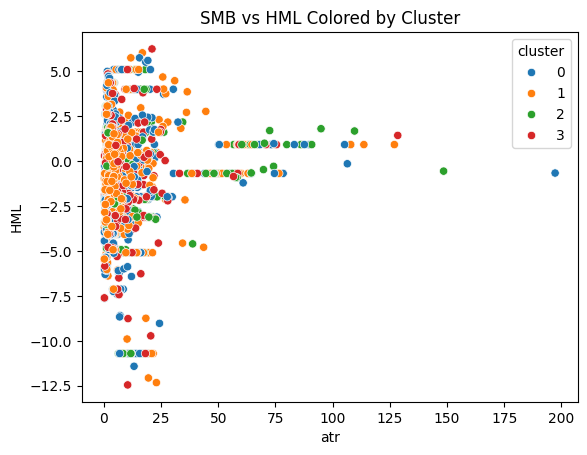

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    x=data['atr'], 
    y=data['HML'], 
    hue=data['cluster'],  # color by cluster
    palette='tab10'  # optional: change color scheme
)
plt.title("SMB vs HML Colored by Cluster")
plt.show()



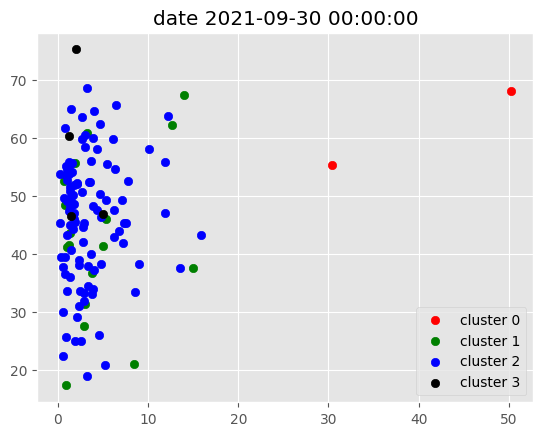

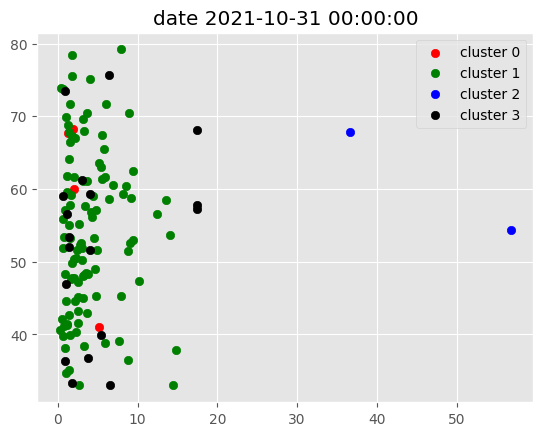

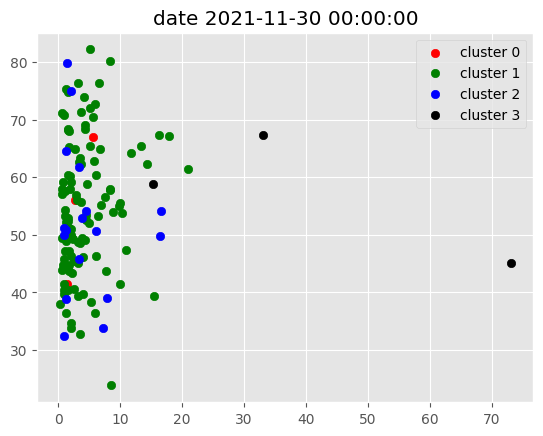

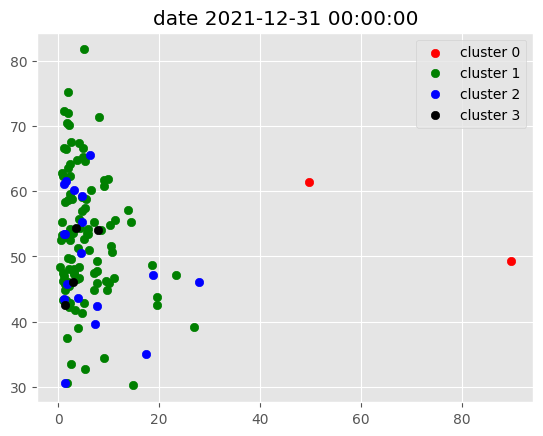

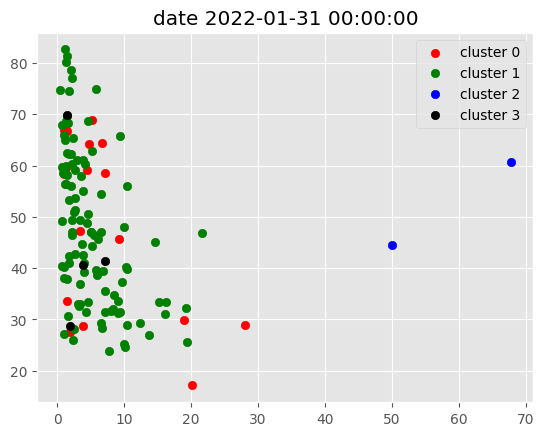

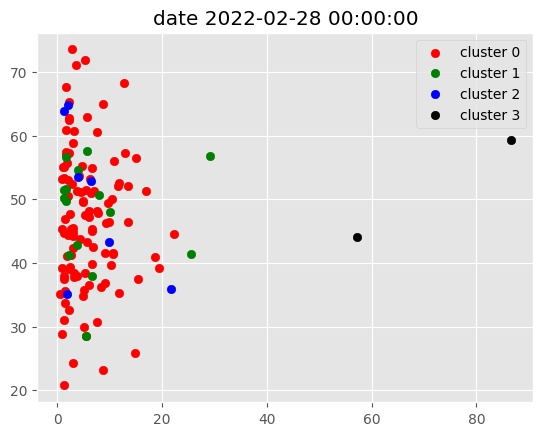

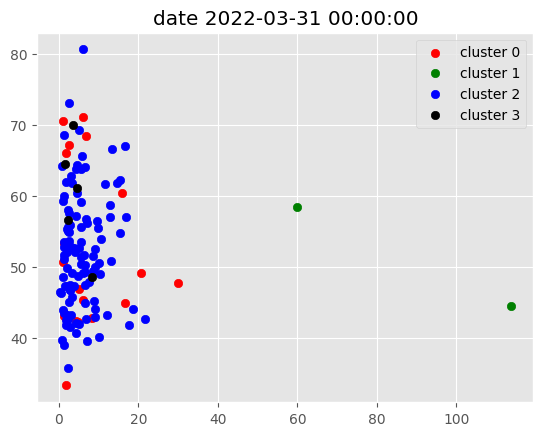

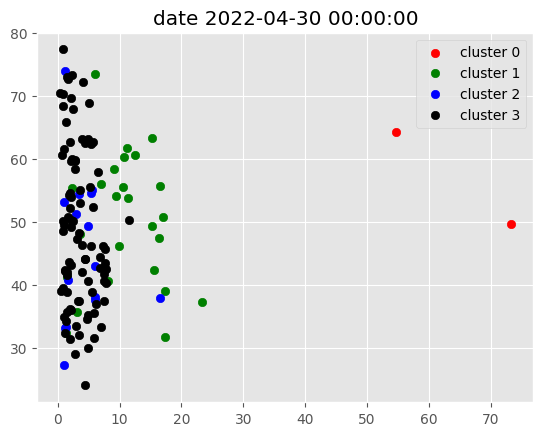

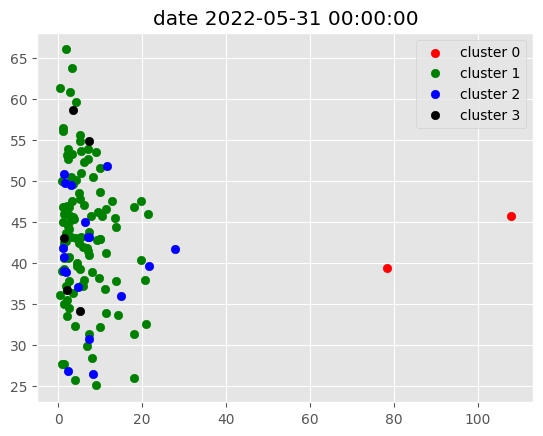

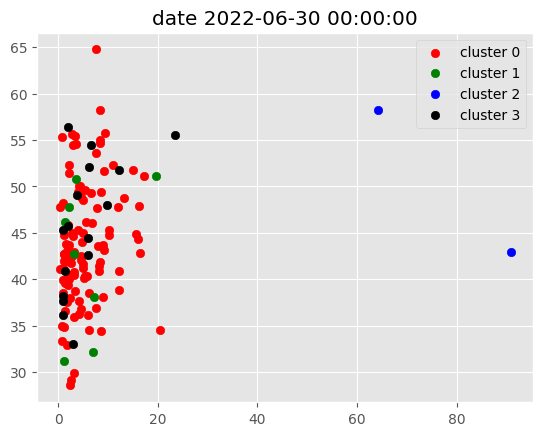

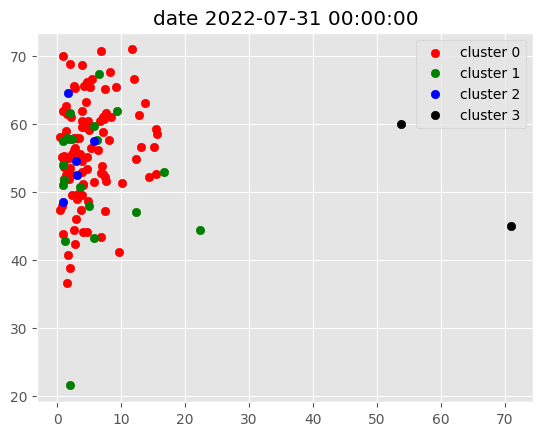

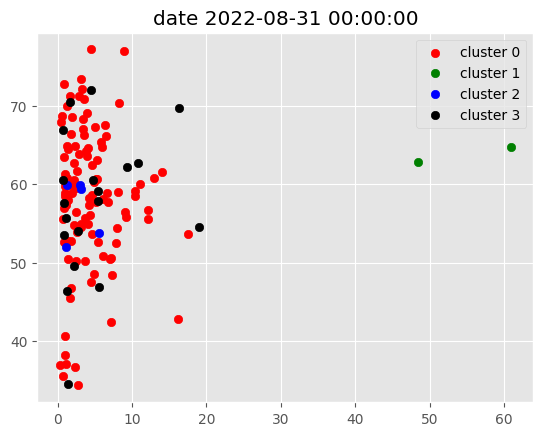

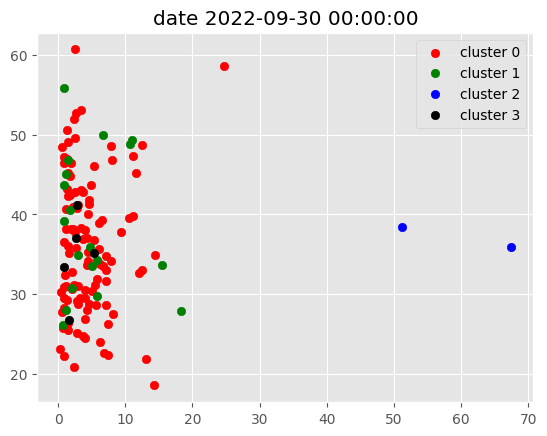

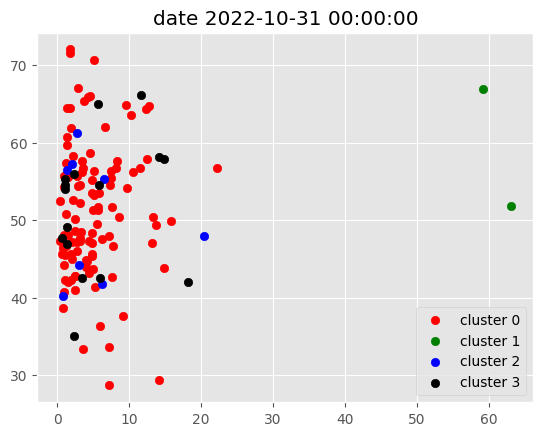

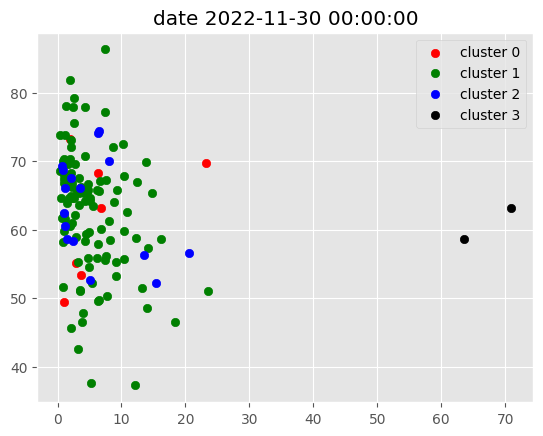

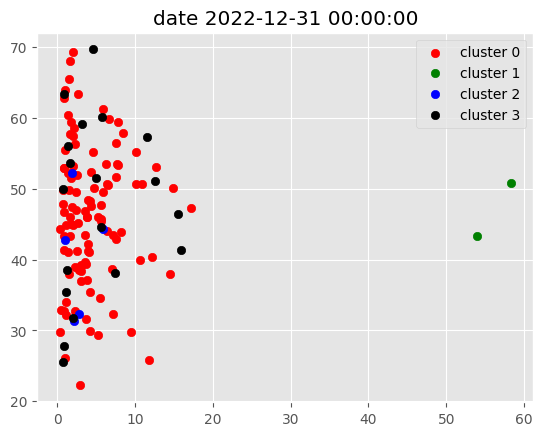

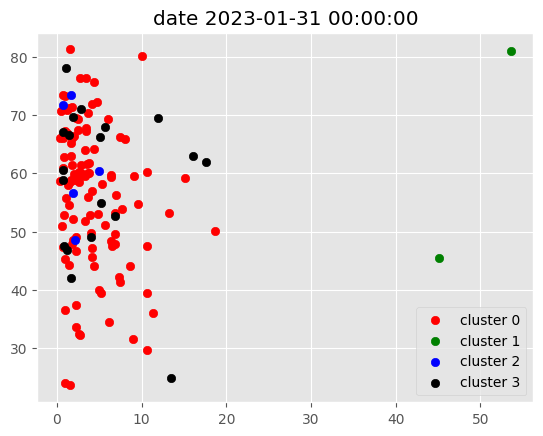

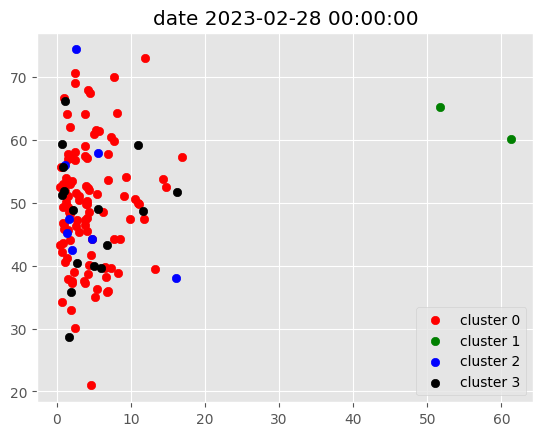

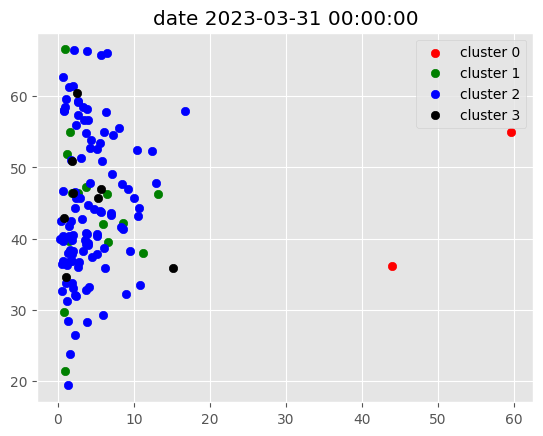

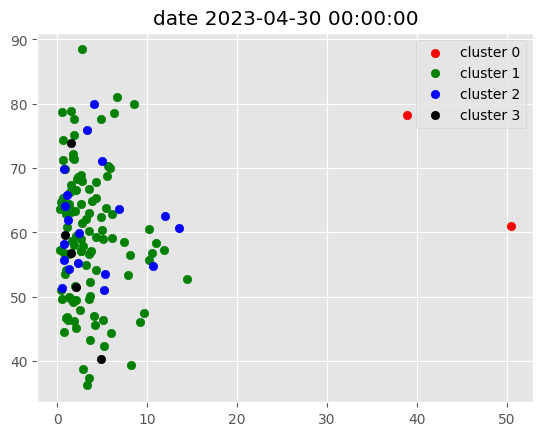

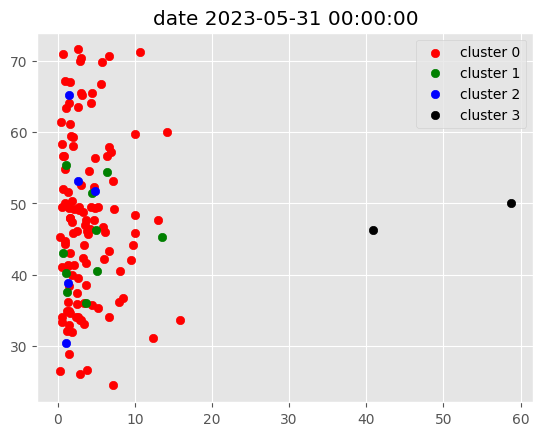

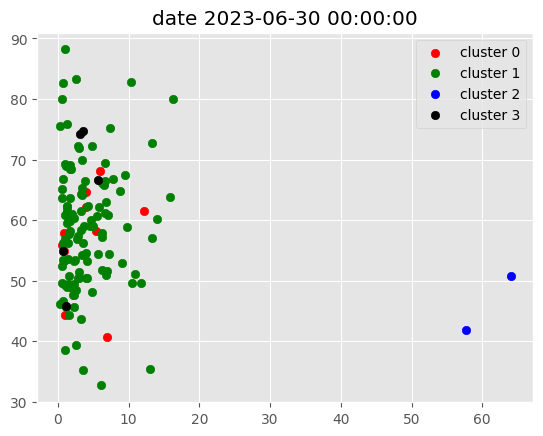

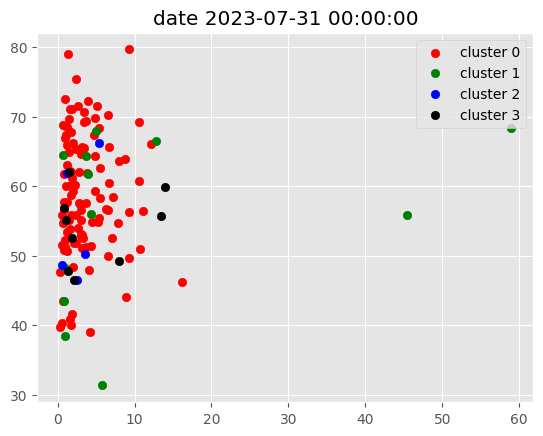

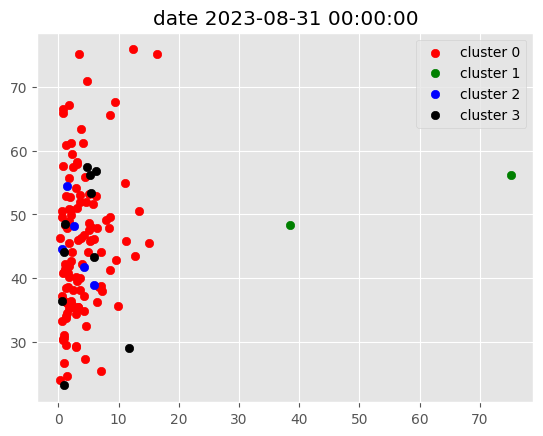

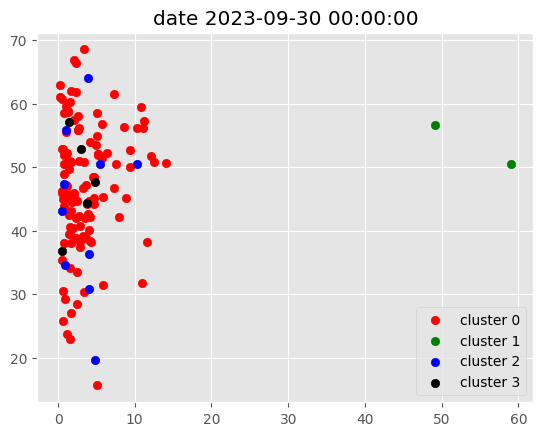

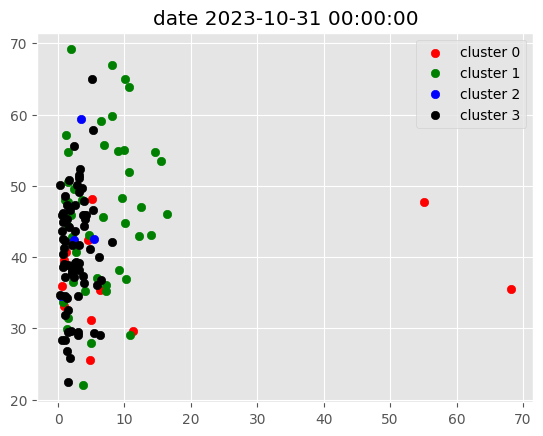

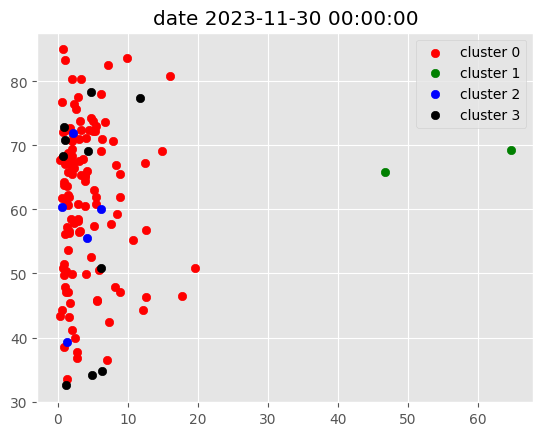

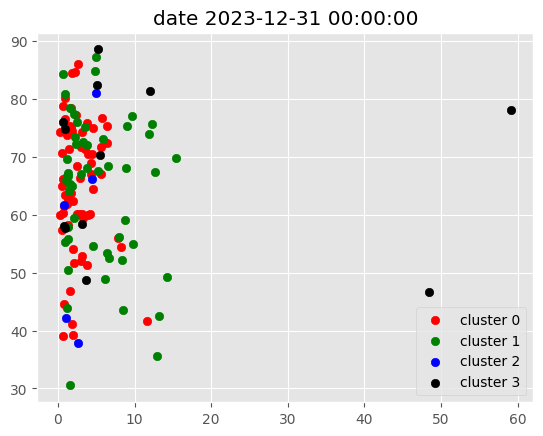

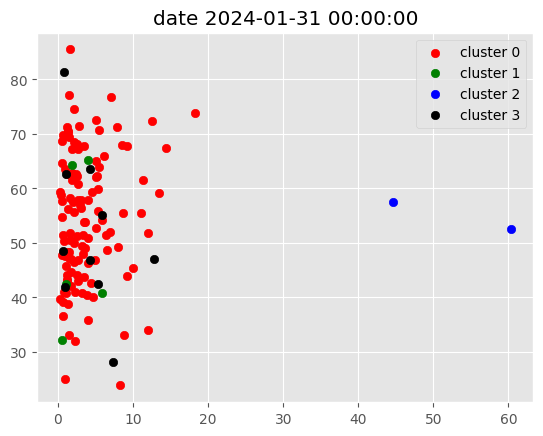

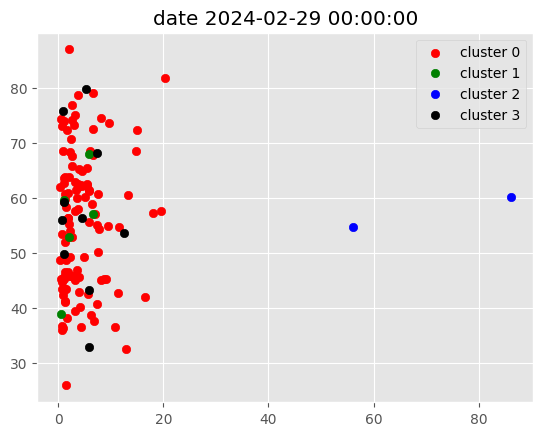

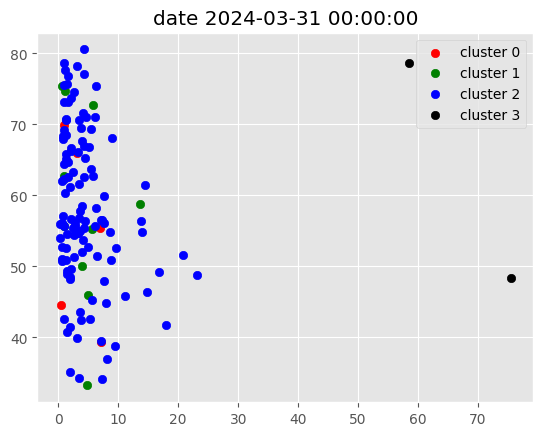

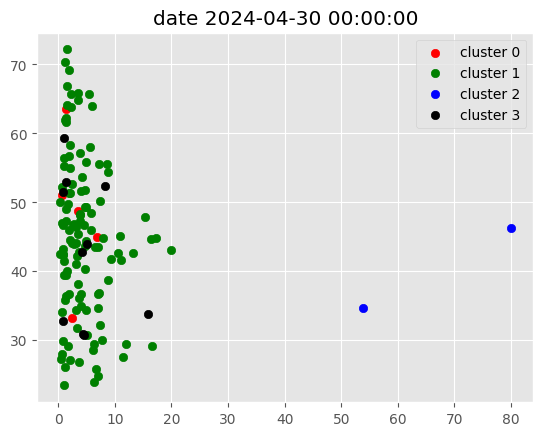

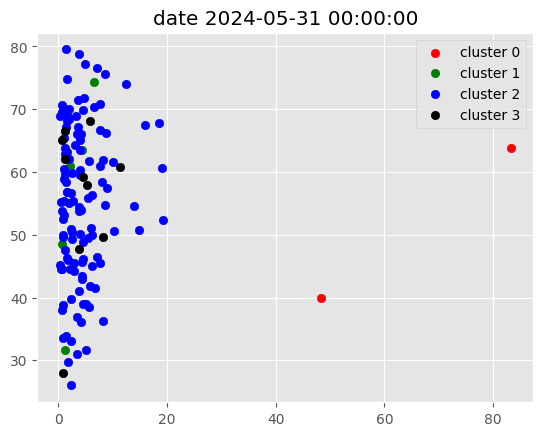

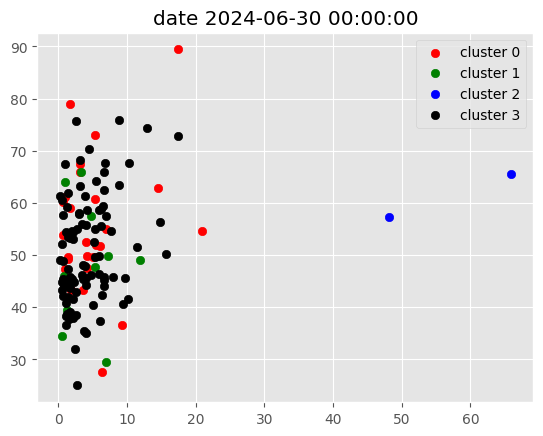

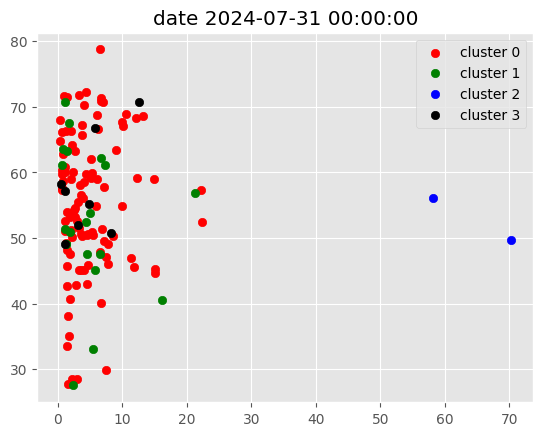

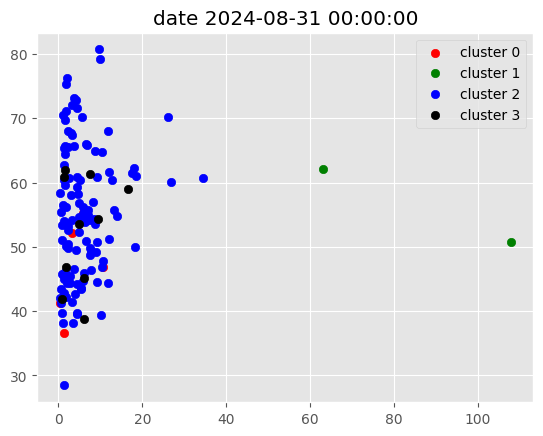

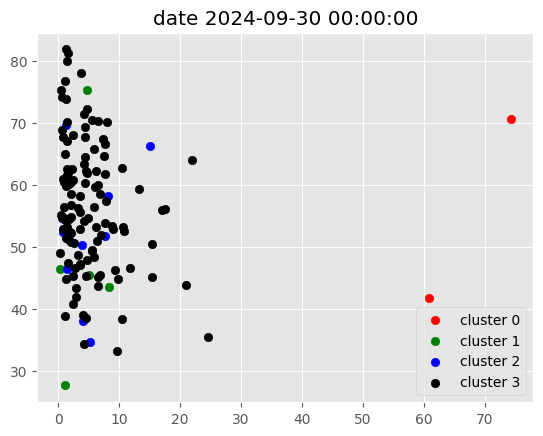

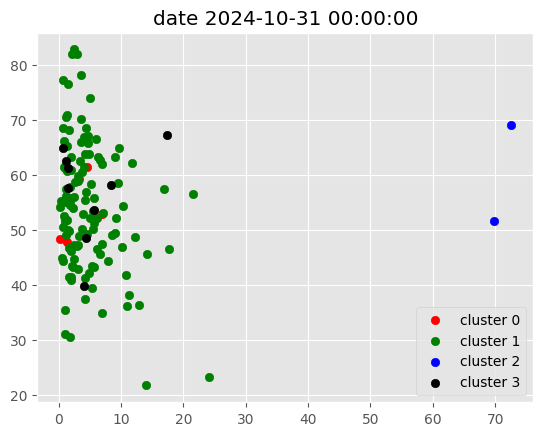

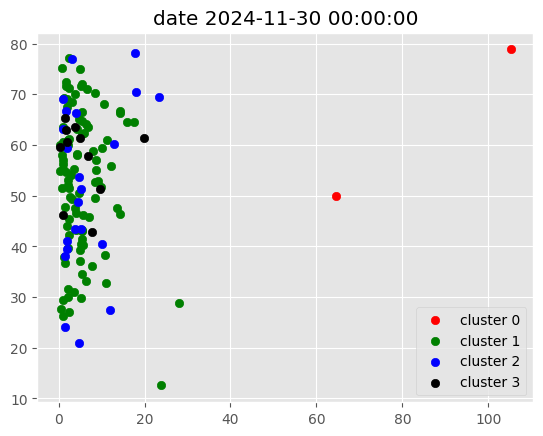

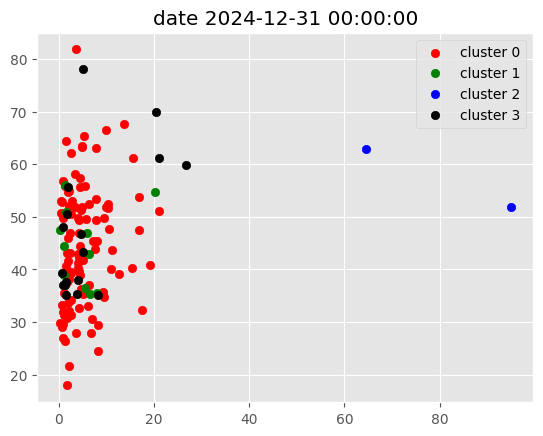

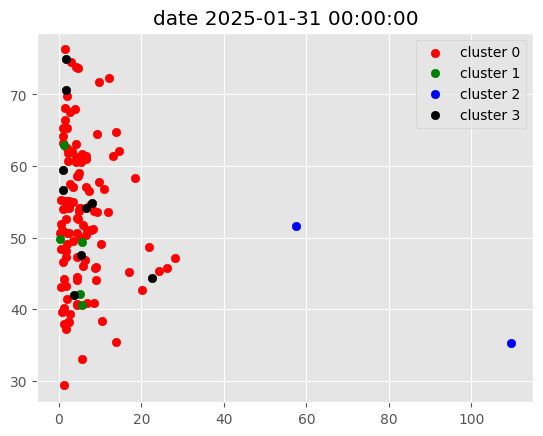

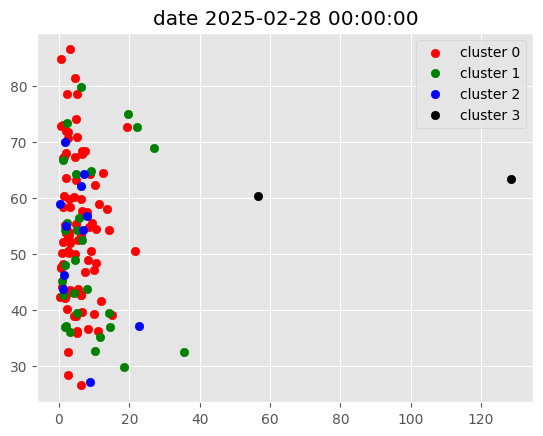

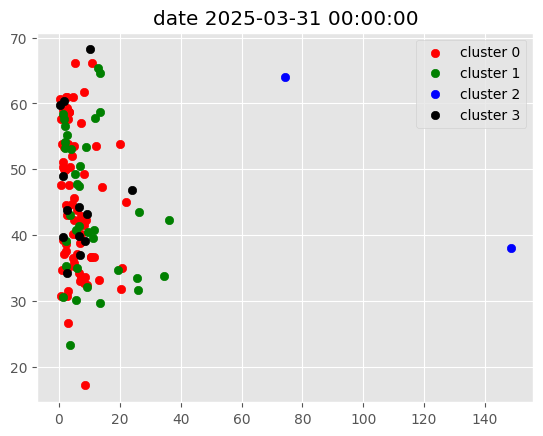

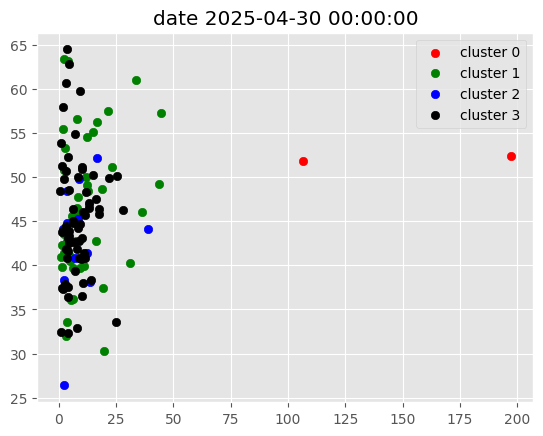

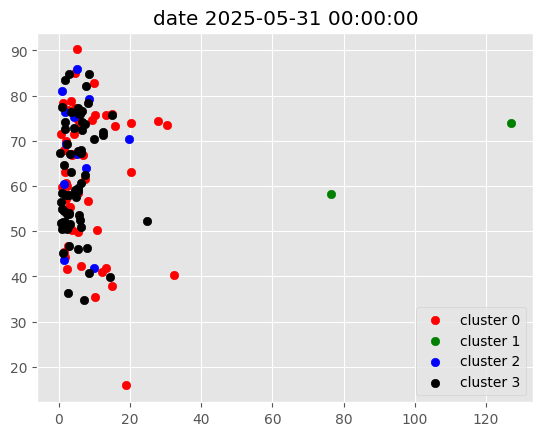

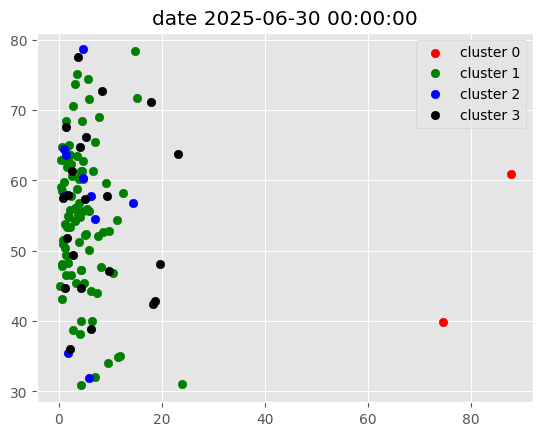

In [43]:
def plot_clusters(data):
    cluster0 = data[data['cluster']==0]
    cluster1 = data[data['cluster']==1]
    cluster2 = data[data['cluster']==2]
    cluster3 = data[data['cluster']==3]

    plt.scatter(cluster0['atr'],cluster0['rsi'],color='red',label='cluster 0')
    plt.scatter(cluster1['atr'],cluster1['rsi'],color='green',label='cluster 1')
    plt.scatter(cluster2['atr'],cluster2['rsi'],color='blue',label='cluster 2')
    plt.scatter(cluster3['atr'],cluster3['rsi'],color='black',label='cluster 3')

    plt.legend()
    plt.show()
    return

plt.style.use('ggplot')
for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i,level=0)
    plt.title(f'date {i}')
    plot_clusters(g)

In [44]:
target_rsi_values =[30,45,55,70]
initial_centroids = np.zeros((len(target_rsi_values), 21))

initial_centroids[:,8] = target_rsi_values
initial_centroids


array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [45]:
filtered_df = data[data['cluster']==3]
filtered_df

close  garman_klass_vol       sma20        std20  \
date       tickers                                                           
2021-09-30 NXPI      196.705738          0.000189  400.701289  1101.012725   
           ORCL       84.127802          0.000177  370.934682  1102.996466   
           OXY        25.738782          0.000649  353.104839  1106.152325   
           PANW       79.122619          0.000226  324.572018  1105.452888   
2021-10-31 MU         67.334808          0.000241  268.220682   314.520018   
...                         ...               ...         ...          ...   
2025-06-30 GE        244.498462          0.000237  225.284750   379.437492   
           GILD      109.570581          0.000346  227.167856   381.292286   
           GM         48.370117          0.000225  204.911400   384.842124   
           HD        361.841013          0.000115  215.385375   260.740502   
           COST     1010.000765          0.000116  200.857789   220.202268   

                          upper        lower      macd        atr        rsi  \
date       tickers                                                             
2021-09-30 NXPI     2602.726739 -1801.324160  0.780982   5.043165  46.910833   
           ORCL     2576.927613 -1835.058250  0.131854   1.494409  46.480468   
           OXY      2565.409490 -1859.199811  0.186582   1.209101  60.278110   
           PANW     2535.477794 -1886.333758  3.321082   2.030539  75.309720   
2021-10-31 MU        897.260718  -360.819354 -1.148040   1.745912  33.276783   
...                         ...          ...       ...        ...        ...   
2025-06-30 GE        984.159733  -533.590234  9.474012   5.280552  66.198190   
           GILD      989.752428  -535.416717  1.638545   2.685312  61.384055   
           GM        974.595647  -564.772847  0.297661   1.224059  44.669335   
           HD        736.866380  -306.095630  0.363811   6.218487  38.855349   
           COST      641.262326  -239.546747  5.844900  19.583399  48.176951   

                    return 1m  ...  return 3m  return 6m  return 9m  \
date       tickers             ...                                    
2021-09-30 NXPI     -0.016179  ...   0.044583   0.110839   0.333670   
           ORCL     -0.006914  ...   0.112319   0.309738   0.444816   
           OXY       0.077218  ...  -0.089966  -0.047911   0.482622   
           PANW      0.187534  ...   0.300541   0.425668   0.439995   
2021-10-31 MU       -0.061973  ...  -0.109020  -0.237582  -0.135545   
...                       ...  ...        ...        ...        ...   
2025-06-30 GE        0.084177  ...   0.219083   0.440211   0.384994   
           GILD      0.061102  ...  -0.011657   0.205556   0.369619   
           GM        0.003572  ...   0.001421  -0.077713   0.036710   
           HD       -0.013156  ...   0.000596  -0.104502  -0.034908   
           COST     -0.004240  ...   0.070849   0.043837   0.128964   

                    return 12m    Mkt-RF       SMB       HML       RMW  \
date       tickers                                                       
2021-09-30 NXPI       0.706235  2.359575 -1.179974  0.158556  1.036937   
           ORCL       0.533780  2.016139 -2.774345 -1.752725  1.742051   
           OXY        1.444475 -2.283134  3.857898 -3.523241  0.372838   
           PANW       0.948943  0.648055  0.021280 -2.387923 -0.657733   
2021-10-31 MU         0.356655  0.352301 -5.239435  1.838923 -4.097587   
...                        ...       ...       ...       ...       ...   
2025-06-30 GE         0.527485  2.897787 -2.029725  0.859298 -4.175394   
           GILD       0.719479  1.055600 -1.795665 -2.303312  1.712460   
           GM         0.044439 -0.277966 -3.067288 -1.644743 -0.303281   
           HD         0.086344  0.647935 -2.719996 -0.047454  1.591081   
           COST       0.196386  1.645423 -0.720692  0.393834 -1.231426   

                         CMA  cluster  
date       tickers                     
202

In [46]:
filtered_df=filtered_df.reset_index(level=1)

In [47]:
filtered_df.index = filtered_df.index + pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date','tickers'])

In [48]:
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d,level = 0).index.tolist()

fixed_dates

{'2021-10-01': ['NXPI', 'ORCL', 'OXY', 'PANW'],
 '2021-11-01': ['MU',
  'NEE',
  'NEM',
  'NFLX',
  'NKE',
  'NOC',
  'NOW',
  'NVDA',
  'BLK',
  'BMY',
  'BRK-B',
  'BSX',
  'C',
  'BIIB',
  'CAT',
  'BDX',
  'BAC',
  'BA'],
 '2021-12-01': ['BKNG', 'BLK', 'AZO'],
 '2022-01-01': ['ORCL', 'NXPI', 'OXY', 'PANW'],
 '2022-02-01': ['NXPI', 'ORCL', 'OXY', 'PANW'],
 '2022-03-01': ['BKNG', 'AZO'],
 '2022-04-01': ['PARA', 'NXPI', 'ORCL', 'OXY', 'PANW'],
 '2022-05-01': ['LLY',
  'MSFT',
  'MS',
  'MDLZ',
  'MPC',
  'PEP',
  'LOW',
  'LRCX',
  'MAR',
  'MCD',
  'MDT',
  'META',
  'MMM',
  'MRK',
  'PFE',
  'PM',
  'UNP',
  'UPS',
  'USB',
  'V',
  'VZ',
  'WDAY',
  'WFC',
  'WMT',
  'LIN',
  'UAL',
  'PG',
  'TXN',
  'TMUS',
  'PYPL',
  'QCOM',
  'RCL',
  'RTX',
  'SBUX',
  'SCHW',
  'SLB',
  'T',
  'TGT',
  'TJX',
  'XOM',
  'JPM',
  'CI',
  'CMCSA',
  'CMG',
  'COP',
  'CCL',
  'KO',
  'ABBV',
  'ABT',
  'ACN',
  'ADI',
  'ADP',
  'ADSK',
  'AMAT',
  'AMD',
  'AMGN',
  'AMT',
  'AMZN',
  'AVGO'

In [49]:
#Create portfolio
#defining portfolio optimization function
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


def optimize_weight(prices,lower_bound=0):
    returns= expected_returns.mean_historical_return(prices = prices,frequency = 252)
    cov = risk_models.sample_cov(prices= prices,
                               frequency = 252)
    ef = EfficientFrontier(expected_returns=returns,
                          cov_matrix=cov,
                          weight_bounds=(0,1),
                          solver="SCS")
    weights =ef.max_sharpe()
    return ef.clean_weights()

    

In [50]:
stocks = data.index.get_level_values(level=1).unique().tolist()
stocks

['AAPL',
 'MS',
 'MSFT',
 'MU',
 'NEE',
 'NEM',
 'NFLX',
 'MRK',
 'NKE',
 'NOW',
 'NVDA',
 'NXPI',
 'ORCL',
 'OXY',
 'NOC',
 'PANW',
 'MPC',
 'MMM',
 'LMT',
 'LOW',
 'LRCX',
 'LULU',
 'MA',
 'MCD',
 'MDLZ',
 'MDT',
 'META',
 'MAR',
 'PFE',
 'PG',
 'PM',
 'UNH',
 'UNP',
 'UPS',
 'USB',
 'V',
 'VRTX',
 'VZ',
 'WDAY',
 'WFC',
 'WMT',
 'XOM',
 'UAL',
 'TXN',
 'TSLA',
 'PYPL',
 'QCOM',
 'RCL',
 'REGN',
 'RTX',
 'SBUX',
 'SCHW',
 'SHW',
 'SLB',
 'T',
 'TGT',
 'TJX',
 'TMO',
 'TMUS',
 'LLY',
 'LIN',
 'PEP',
 'KO',
 'BLK',
 'BMY',
 'BRK-B',
 'BSX',
 'C',
 'CAT',
 'BIIB',
 'CCL',
 'CI',
 'CMCSA',
 'CMG',
 'COP',
 'COST',
 'CRM',
 'CHTR',
 'BDX',
 'BAC',
 'BA',
 'ABBV',
 'ABT',
 'ACN',
 'ADBE',
 'ADP',
 'ADSK',
 'AMAT',
 'AMD',
 'AMGN',
 'AMT',
 'AMZN',
 'AVGO',
 'AXP',
 'AZO',
 'CSCO',
 'CSX',
 'BKNG',
 'JPM',
 'GILD',
 'GM',
 'GOOG',
 'GOOGL',
 'HD',
 'GE',
 'HON',
 'IBM',
 'INTC',
 'INTU',
 'ISRG',
 'JNJ',
 'CVS',
 'HUM',
 'FIS',
 'GS',
 'FDX',
 'CVX',
 'FI',
 'DE',
 'DG',
 'DHR',
 'DIS',
 'D

In [51]:
new_df = yf.download(tickers=stocks,
                    start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                    end=data.index.get_level_values('date').unique()[-1])

[*********************100%***********************]  133 of 133 completed


In [52]:
new_df.head()

Price            Close                                                \
Ticker            AAPL       ABBV        ABT         ACN        ADBE   
Date                                                                   
2020-09-30  112.778290  72.238869  99.988686  210.576675  490.429993   
2020-10-01  113.732651  71.867737  99.814133  209.821915  499.510010   
2020-10-02  110.061310  71.026512  97.847969  207.231522  478.989990   
2020-10-05  113.450241  72.519279  99.740616  208.247177  486.470001   
2020-10-06  110.197662  70.836807  97.618286  205.321381  478.980011   

Price                                                                 ...  \
Ticker             ADI         ADP        ADSK       AMAT        AMD  ...   
Date                                                                  ...   
2020-09-30  107.304695  126.528343  231.009995  57.037861  81.989998  ...   
2020-10-01  109.372833  124.904663  233.960007  58.189190  84.860001  ...   
2020-10-02  104.795341  125.784508  225.559998  55.848175  81.800003  ...   
2020-10-05  107.175995  127.861740  228.929993  58.141201  86.150002  ...   
2020-10-06  106.201675  129.040878  228.009995  57.949326  84.480003  ...   

Price        Volume                                                         \
Ticker          UNP      UPS      USB        V     VRTX        VZ     WDAY   
Date                                                                         
2020-09-30  3606200  5426700  9457500  9157600  1382800  16348400  2123400   
2020-10-01  3147100  4934100  4618100  7234600   932500  14547100  2389800   
2020-10-02  3231400  4482700  5406100  6019700  1339100  10741800  1680400   
2020-10-05  3376200  2739000  5471700  6090500  1302900  10457400  1309400   
2020-10-06  3403800  3671400  6061100  5841100  1022800  12524900  1463200   

Price                                     
Ticker           WFC       WMT       XOM  
Date                                      
2020-09-30  43071500  34826400  22223700  
2020-10-01  38879800  43290900  36890200  
2020-10-02  26238600  24585000  32694300  
2020-10-05  22607500  14259000  22965200  
2020-10-06  30991300  21475500  26731800  

[5 rows x 665 columns]

In [53]:
returns = np.log(new_df['Close']).diff()
returns

Ticker,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,ADSK,AMAT,AMD,...,UNP,UPS,USB,V,VRTX,VZ,WDAY,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01,0.008427,-0.005151,-0.001747,-0.003591,0.018345,0.019090,-0.012916,0.012689,0.019984,0.034406,...,-0.013501,0.006103,0.004176,0.016761,0.005095,-0.000672,0.024746,0.002124,0.022405,-0.035581
2020-10-02,-0.032813,-0.011774,-0.019895,-0.012423,-0.041948,-0.042753,0.007019,-0.036564,-0.041063,-0.036726,...,0.010856,-0.004124,0.021163,-0.009338,-0.047584,-0.003539,-0.007008,0.018087,-0.018196,-0.004538
2020-10-05,0.030327,0.020799,0.019158,0.004889,0.015496,0.022463,0.016379,0.014830,0.040238,0.051813,...,0.024997,0.013091,0.025773,0.010272,0.030883,0.007065,0.013877,0.018993,0.009210,0.022783
2020-10-06,-0.029089,-0.023474,-0.021508,-0.014149,-0.015516,-0.009132,0.009180,-0.004027,-0.003306,-0.019575,...,-0.009533,0.001123,-0.008250,-0.015298,-0.030193,-0.003358,-0.022914,-0.011104,-0.008285,-0.010428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-12,0.002111,0.004793,0.008612,-0.003420,0.002033,-0.001808,-0.008423,0.006047,0.012709,-0.022034,...,-0.001019,-0.002375,-0.000905,-0.005130,0.016702,-0.013349,-0.002669,-0.012354,-0.010177,0.003835
2025-06-13,-0.013901,-0.006988,-0.006101,-0.020387,-0.054648,-0.031021,-0.004520,-0.021703,-0.025523,-0.019944,...,-0.009446,-0.009158,-0.026852,-0.051237,-0.010071,-0.003482,-0.024838,-0.022547,-0.004121,0.021547
2025-06-16,0.009978,-0.001152,-0.011942,0.008370,0.025335,0.029641,0.003546,0.024145,0.034341,0.084404,...,0.005714,0.010841,0.003715,0.007426,-0.010018,-0.011929,0.004529,0.010858,-0.001590,0.003206


In [54]:
portfolio_df = pd.DataFrame()
for start_date in fixed_dates.keys():
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

    cols = fixed_dates[start_date]

    optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    print(optimization_end_date)
    print(optimization_start_date)

2021-09-30
2020-10-01
2021-10-31
2020-11-01
2021-11-30
2020-12-01
2021-12-31
2021-01-01
2022-01-31
2021-02-01
2022-02-28
2021-03-01
2022-03-31
2021-04-01
2022-04-30
2021-05-01
2022-05-31
2021-06-01
2022-06-30
2021-07-01
2022-07-31
2021-08-01
2022-08-31
2021-09-01
2022-09-30
2021-10-01
2022-10-31
2021-11-01
2022-11-30
2021-12-01
2022-12-31
2022-01-01
2023-01-31
2022-02-01
2023-02-28
2022-03-01
2023-03-31
2022-04-01
2023-04-30
2022-05-01
2023-05-31
2022-06-01
2023-06-30
2022-07-01
2023-07-31
2022-08-01
2023-08-31
2022-09-01
2023-09-30
2022-10-01
2023-10-31
2022-11-01
2023-11-30
2022-12-01
2023-12-31
2023-01-01
2024-01-31
2023-02-01
2024-02-29
2023-03-01
2024-03-31
2023-04-01
2024-04-30
2023-05-01
2024-05-31
2023-06-01
2024-06-30
2023-07-01
2024-07-31
2023-08-01
2024-08-31
2023-09-01
2024-09-30
2023-10-01
2024-10-31
2023-11-01
2024-11-30
2023-12-01
2024-12-31
2024-01-01
2025-01-31
2024-02-01
2025-02-28
2024-03-01
2025-03-31
2024-04-01
2025-04-30
2024-05-01
2025-05-31
2024-06-01
2025-06-30

In [55]:
start_date

'2025-07-01'

In [59]:
weights = optimize_weight(prices = optimization_df,
                          lower_bound=0)

In [57]:
optimization_df = new_df[optimization_start_date:optimization_end_date]['Close'][cols]

In [58]:
optimization_df

Ticker,NEE,NEM,NFLX,NKE,NOC,NOW,NVDA,MU,LLY,LMT,...,TMUS,TJX,TMO,BAC,BA,GE,GILD,GM,HD,COST
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-01,67.874840,40.768959,673.609985,75.217308,427.492676,788.960022,124.260750,130.916519,908.154480,454.454376,...,176.612534,109.172890,539.957092,39.052898,186.699997,157.915115,66.495461,46.193779,328.273621,841.320190
2024-07-02,68.428329,40.827679,679.580017,74.443893,429.821777,794.109985,122.631264,131.981598,900.546631,453.733398,...,177.500137,108.797722,532.192505,39.950893,185.419998,160.378647,66.262962,46.460964,327.082367,854.939819
2024-07-03,69.748917,42.530880,682.510010,73.660683,429.546600,785.919983,128.239487,136.192200,891.995056,454.054871,...,176.001083,108.985306,533.867004,39.921612,184.309998,161.918365,64.509499,46.223465,325.783691,858.222717
2024-07-05,70.001373,43.568451,690.650024,73.846695,427.227325,806.469971,125.790260,130.996140,908.353210,450.284363,...,176.770340,110.219398,538.342346,39.443329,184.830002,159.434967,64.606392,46.035442,326.701538,881.114441
2024-07-08,70.020813,43.196491,685.739990,71.516647,422.824646,766.200012,128.159500,130.204117,911.759827,449.894623,...,176.701294,110.782150,534.544739,39.648308,185.839996,162.444855,65.439514,46.065132,331.603333,876.309326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-12,73.839996,55.919998,1215.030029,62.799999,497.130005,1007.369995,145.000000,116.180000,812.030029,469.269989,...,228.699997,124.459999,414.899994,44.619999,203.750000,239.990005,111.260010,49.259998,363.160004,1002.710022
2025-06-13,74.779999,57.900002,1212.150024,60.529999,516.719971,988.659973,141.970001,115.599998,819.359985,486.450012,...,228.000000,123.910004,402.760010,44.090000,200.320007,236.600006,109.980003,48.650002,354.660004,990.210022
2025-06-16,73.779999,58.119999,1225.349976,61.900002,497.519989,1005.130005,144.690002,119.839996,807.580017,467.059998,...,230.990005,124.269997,405.079987,44.410000,201.699997,236.539993,110.830002,49.270000,353.559998,984.359985


In [60]:
weights
#we have our final portfolio weights
#We change the 

OrderedDict([('NEE', 0.0),
             ('NEM', 0.05789),
             ('NFLX', 0.40395),
             ('NKE', 0.0),
             ('NOC', 0.06222),
             ('NOW', 0.0),
             ('NVDA', 0.0),
             ('MU', 0.0),
             ('LLY', 0.0),
             ('LMT', 0.0),
             ('TGT', 0.0),
             ('TSLA', 0.0),
             ('TMUS', 0.0),
             ('TJX', 0.0),
             ('TMO', 0.0),
             ('BAC', 0.0),
             ('BA', 0.0),
             ('GE', 0.0),
             ('GILD', 0.47595),
             ('GM', 0.0),
             ('HD', 0.0),
             ('COST', 0.0)])

## Twitter Sentiment Investing Strategy

In [61]:
twitter_data = pd.read_csv('sentiment_data (1).csv')
twitter_data

,date,symbol,twitterPosts,twitterComments,twitterLikes,twitterImpressions,twitterSentiment
0,2021-11-18,AAPL,811.0,2592.0,21674.0,7981808.0,NaN
1,2021-11-18,ABT,21.0,3.0,13.0,64089.0,NaN
2,2021-11-18,AMD,150.0,675.0,2949.0,1645270.0,NaN
3,2021-11-18,AMZN,557.0,1315.0,12969.0,5590695.0,NaN
4,2021-11-18,ATVI,82.0,36.0,131.0,1310715.0,NaN
...,...,...,...,...,...,...,...
27230,2023-01-04,TMO,21.0,2.0,32.0,30857.0,0.610020
27231,2023-01-04,TSLA,6767.0,540711.0,3810688.0,55464921.0,0.543057
27232,2023-01-04,TSN,35.0,168.0,460.0,57207.0,0.561900
27233,2023-01-04,V,132.0,1008.0,5943.0,139835.0,0.567286


In [62]:
twitter_data.date = pd.to_datetime(twitter_data.date)
twitter_data =twitter_data.set_index(['date','symbol'])

In [63]:
twitter_data['engagement_ratio'] = twitter_data['twitterComments']/twitter_data['twitterLikes']
twitter_data = twitter_data[(twitter_data['twitterLikes']>20) & (twitter_data['twitterComments']>10)]

In [64]:
twitter_data

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

In [65]:
# Step 1: Ensure 'date' in MultiIndex is datetime
twitter_data.index = twitter_data.index.set_levels(
    pd.to_datetime(twitter_data.index.levels[0]), level=0
)

# Step 2: Reset index to get 'date' and 'symbol' as columns
twitter_reset = twitter_data.reset_index()

# Step 3: Group by Month Start and Symbol, then average engagement_ratio
monthly_avg = (
    twitter_reset
    .groupby([pd.Grouper(key='date', freq='MS'), 'symbol'])['engagement_ratio']
    .mean()
    .reset_index()
)

# Step 4: Sort values (optional)
monthly_avg = monthly_avg.sort_values(['date', 'symbol'])

monthly_avg = monthly_avg.set_index(['date','symbol'])


In [66]:
monthly_avg

engagement_ratio
date       symbol                  
2021-11-01 AAL             0.203835
           AAPL            0.256318
           ABBV            0.244677
           ABT             0.313368
           AES             0.864613
...                             ...
2023-01-01 TMO             0.333313
           TSLA            0.151992
           TSN             0.280553
           V               0.194045
           XOM             0.217904

[1109 rows x 1 columns]

In [67]:
monthly_avg['rank'] = (monthly_avg.groupby(level=0)['engagement_ratio']
                       .transform(lambda x: x.rank(ascending=False)))

In [68]:
#Selecting top 5 stocks
monthly_avg = monthly_avg[monthly_avg['rank']<=5]
monthly_avg

engagement_ratio  rank
date       symbol                        
2021-11-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
...                             ...   ...
2023-01-01 A               0.471572   5.0
           AES             0.533809   4.0
           BIIB            0.839303   1.0
           FCX             0.667387   3.0
           MDT             0.806841   2.0

[75 rows x 2 columns]

In [69]:
monthly_avg = monthly_avg.reset_index('symbol')
monthly_avg.index = monthly_avg.index+pd.DateOffset(1)

In [70]:
monthly_avg

,symbol,engagement_ratio,rank
date,,,
2021-11-02,AES,0.864613,2.0
2021-11-02,FCX,0.626323,5.0
2021-11-02,MNST,0.699721,3.0
2021-11-02,OXY,2.147741,1.0
2021-11-02,SLB,0.647374,4.0
...,...,...,...
2023-01-02,A,0.471572,5.0
2023-01-02,AES,0.533809,4.0
2023-01-02,BIIB,0.839303,1.0


In [71]:
monthly_avg = monthly_avg.reset_index()  # in case 'date' is still in index

# Step 2: Convert 'date' to datetime (safety step)
monthly_avg['date'] = pd.to_datetime(monthly_avg['date'])

# Step 3: Extract unique monthly dates to iterate over (convert to periods)
dates = pd.to_datetime(monthly_avg['date'].unique())
fixed_dates = {}

# Step 4: Group based on year + month (ignoring day)
for d in dates:
    month_period = d.to_period('M')
    
    matching_symbols = monthly_avg[
        monthly_avg['date'].dt.to_period('M') == month_period
    ]['symbol'].tolist()
    
    fixed_dates[d.strftime('%Y-%m-%d')] = matching_symbols

In [72]:
fixed_dates

{'2021-11-02': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2021-12-02': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-01-02': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-02-02': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-03-02': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-04-02': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-05-02': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-06-02': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-07-02': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-08-02': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-09-02': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-10-02': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-11-02': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2022-12-02': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-01-02': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

In [73]:
stocks_list = twitter_data.index.get_level_values('symbol').unique().tolist()
prices =yf.download(stocks_list,
                   start='2021-01-01',
                   end='2023-03-01')
prices

[*********************100%***********************]  85 of 85 completed

18 Failed downloads:
['PEP']: Timeout('Failed to perform, curl: (28) Resolving timed out after 10011 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['BMY', 'HBAN']: Timeout('Failed to perform, curl: (28) Resolving timed out after 10007 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['RCL']: Timeout('Failed to perform, curl: (28) Resolving timed out after 10005 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['T', 'PM']: Timeout('Failed to perform, curl: (28) Resolving timed out after 10004 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['DG']: Timeout('Failed to perform, curl: (28) Resolving timed out after 10016 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['LUV']: Timeout('Failed to perform, curl: (28

Price      Adj Close                                           ... Volume  \
Ticker          ATVI BMY  DD  DG DLTR   F GOOGL HBAN ILMN LUV  ...    RCL   
Date                                                           ...          
2021-01-04       NaN NaN NaN NaN  NaN NaN   NaN  NaN  NaN NaN  ...    NaN   
2021-01-05       NaN NaN NaN NaN  NaN NaN   NaN  NaN  NaN NaN  ...    NaN   
2021-01-06       NaN NaN NaN NaN  NaN NaN   NaN  NaN  NaN NaN  ...    NaN   
2021-01-07       NaN NaN NaN NaN  NaN NaN   NaN  NaN  NaN NaN  ...    NaN   
2021-01-08       NaN NaN NaN NaN  NaN NaN   NaN  NaN  NaN NaN  ...    NaN   
...              ...  ..  ..  ..  ...  ..   ...  ...  ...  ..  ...    ...   
2023-02-22       NaN NaN NaN NaN  NaN NaN   NaN  NaN  NaN NaN  ...    NaN   
2023-02-23       NaN NaN NaN NaN  NaN NaN   NaN  NaN  NaN NaN  ...    NaN   
2023-02-24       NaN NaN NaN NaN  NaN NaN   NaN  NaN  NaN NaN  ...    NaN   
2023-02-27       NaN NaN NaN NaN  NaN NaN   NaN  NaN  NaN NaN  ...    NaN   
2023-02-28       NaN NaN NaN NaN  NaN NaN   NaN  NaN  NaN NaN  ...    NaN   

Price                                                                    \
Ticker         REGN       SLB      STZ   T      TMO       TSLA      TSN   
Date                                                                      
2021-01-04   911100   8743400  1202600 NaN  2220400  145914600  2177400   
2021-01-05   797700  16256600  1530200 NaN  2046700   96735600  2297100   
2021-01-06  1434700  19456300  1861700 NaN  2112300  134100000  1942200   
2021-01-07  1126600  14502400  2537100 NaN  2144400  154496700  2969400   
2021-01-08  1018800  11951900  1595400 NaN  2221700  225166500  2672400   
...             ...       ...      ...  ..      ...        ...      ...   
2023-02-22   415500   9181100  1092200 NaN  1705300  191828500  4217700   
2023-02-23   553300   6324500   979700 NaN  1160200  146360000  3403500   
2023-02-24   525900   8458700   702900 NaN   852600  142228100  2439300   
2023-02-27   557100   6287000   608200 NaN  1110600  161028300  3922200   
2023-02-28   622700  10634200  1136900 NaN  1188800  153144900  3556300   

Price                           
Ticker             V       XOM  
Date                            
2021-01-04  10318300  27764700  
2021-01-05   6869700  44035100  
2021-01-06   7206200  36484800  
2021-01-07  10967900  29528100  
2021-01-08   6513000  28628200  
...              ...       ...  
2023-02-22   4621800  13973800  
2023-02-23   5533800  11289400  
2023-02-24   4414400  14351000  
2023-02-27   4255300  11710500  
2023-02-28   5385400  18107000  

[542 rows x 443 columns]

In [74]:
prices = prices.drop('Adj Close', axis = 1)

In [75]:
returns_data = np.log(prices.Close).diff()*100
returns_data

Ticker,A,AAL,AAP,AAPL,ABBV,ABT,AEP,AES,ALB,AMD,...,RCL,REGN,SLB,STZ,T,TMO,TSLA,TSN,V,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,0.814282,1.963415,-0.108092,1.228802,1.028750,1.229677,-0.134970,3.301192,6.530358,0.507910,...,NaN,0.122121,5.236306,0.069173,NaN,1.242723,0.729073,-0.078758,-1.503697,4.706782
2021-01-06,2.705315,0.581586,5.616466,-3.424115,-0.867616,-0.208431,0.795051,3.918862,7.203689,-2.665362,...,NaN,-2.802375,5.386261,3.100496,NaN,1.555692,2.799477,2.965812,-0.884995,2.519698
2021-01-07,2.626133,-0.906157,0.850494,3.355398,1.064595,0.966010,-2.704361,-1.005847,4.957819,5.209007,...,NaN,2.335882,1.907136,2.275876,NaN,3.068599,7.644847,-1.154127,0.558115,0.781523
2021-01-08,0.710839,-1.638844,1.415365,0.859419,0.523402,0.278134,-0.892698,2.751931,0.054341,-0.611367,...,NaN,3.578185,-0.160909,0.583796,NaN,2.364264,7.548124,-0.901730,0.764105,1.105941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22,-0.938728,-0.831999,-0.396102,0.289187,-0.878875,-0.930512,-0.033018,-0.706431,1.838668,-0.208627,...,NaN,0.208747,-1.871327,-0.444714,NaN,-0.431226,1.752804,1.665894,-0.272329,-1.303771
2023-02-23,0.785205,1.972698,-1.127340,0.328514,0.924914,-0.136423,-0.121205,0.000000,2.958434,4.016912,...,NaN,1.536090,1.721401,1.554573,NaN,0.463917,0.600606,0.999197,0.503243,0.916217
2023-02-24,-1.406495,-1.972698,-2.250317,-1.816951,0.419971,-2.059090,-0.309160,-0.276085,-1.720433,-2.103478,...,NaN,-0.352079,1.118986,-0.671578,NaN,-1.492179,-2.601978,-1.828675,-0.717092,0.009045


In [76]:
portfolio_return = pd.DataFrame()

for start_date in fixed_dates.keys():
    # Compute end date (end of same month)
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    
    # Get the list of stock symbols for this start date
    cols = fixed_dates[start_date]
    
    # Get average return of selected stocks between start_date and end_date
    temp_data = returns_data[start_date:end_date][cols].mean(axis=1).to_frame(name='portfolio_return')
    print(temp_data)
    # Append to main portfolio DataFrame
    portfolio_return = pd.concat([portfolio_return, temp_data],axis =0)


            portfolio_return
Date                        
2021-11-02          0.193356
2021-11-03         -0.030875
2021-11-04         -0.736175
2021-11-05          1.240449
2021-11-08          0.822047
2021-11-09         -0.029385
2021-11-10         -1.870857
2021-11-11          3.069578
2021-11-12         -0.032610
2021-11-15          0.309631
2021-11-16         -0.804328
2021-11-17         -1.668426
2021-11-18         -1.048309
2021-11-19         -1.706147
2021-11-22          0.468638
2021-11-23          0.553503
2021-11-24          0.408062
2021-11-26         -3.824351
2021-11-29          0.170986
2021-11-30         -2.480497
            portfolio_return
Date                        
2021-12-02          3.030418
2021-12-03          0.105315
2021-12-06          2.435701
2021-12-07          2.047978
2021-12-08          0.039294
2021-12-09          0.280893
2021-12-10          0.450373
2021-12-13         -0.704651
2021-12-14         -0.204074
2021-12-15          0.629571
2021-12-16    

In [77]:
portfolio_return

,portfolio_return
Date,
2021-11-02,0.193356
2021-11-03,-0.030875
2021-11-04,-0.736175
2021-11-05,1.240449
2021-11-08,0.822047
...,...
2023-01-25,1.053040
2023-01-26,0.118270
2023-01-27,-0.771150


## Download NASDAQ prices to compare returns

In [78]:
qqq_yf = yf.download(tickers='QQQ',
                    start='2021-11-02',
                    end='2023-01-31')

[*********************100%***********************]  1 of 1 completed


In [79]:
qqq_yf_returns = np.log(qqq_yf.Close).diff()
qqq_yf_returns

Ticker,QQQ
Date,
2021-11-02,NaN
2021-11-03,0.010559
2021-11-04,0.012737
2021-11-05,0.000954
2021-11-08,-0.001356
...,...
2023-01-24,-0.002044
2023-01-25,-0.002222
2023-01-26,0.019310


In [80]:
portfolio_return['qqq_yf_returns'] = qqq_yf_returns['QQQ']*100
portfolio_return.dropna(inplace=True)
portfolio_return.columns = ['pr','qqq']

In [81]:
portfolio_return

,pr,qqq
Date,,
2021-11-03,-0.030875,1.055946
2021-11-04,-0.736175,1.273721
2021-11-05,1.240449,0.095382
2021-11-08,0.822047,-0.135560
2021-11-09,-0.029385,-0.690719
...,...,...
2023-01-24,-0.918058,-0.204372
2023-01-25,1.053040,-0.222186
2023-01-26,0.118270,1.930988


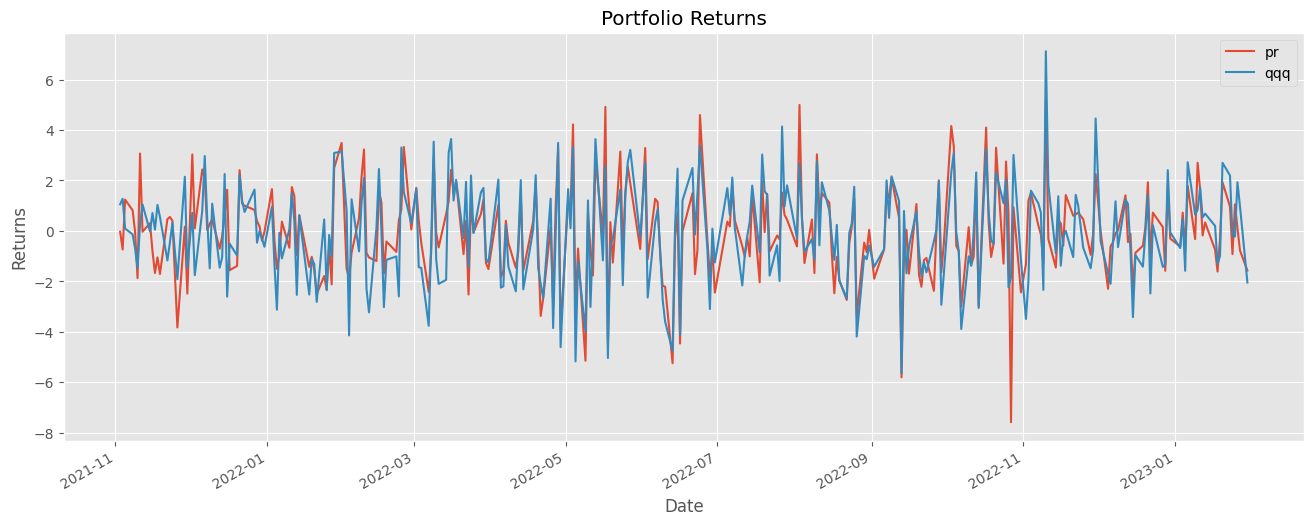

In [88]:
portfolio_return.plot(figsize=(16,6))
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Portfolio Returns')
plt.show()

#This is almost same. So we have verified the NASDAQ dataset with our Twitter sentiment analysis